<a href="https://colab.research.google.com/github/Philliec459/Open-Source-Petrophysics/blob/main/Upscaled_BVocc_BC_Perm/SatHg_LinkedIn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
using_colab = False

In [2]:
if using_colab:

    #!wget 'https://github.com/PDDA-OPDU/MICP-Analytics/raw/main/Upscaled_BVocc_BC_Perm/SatHg_LinkedIn.ipynb'
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/STELLA_brief_ver2_backyard_grass_shoreline.ipynb
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/data_white_grass_shade_whiteshade.xlsx
    #https://github.com/Philliec459/Science-and-Technology-Society-Use-of-NASA-STELLA-Q2-Spectrometer/raw/main/data_white_FullSun.xlsx

    #!pip install lasio
    !pip install jupyter_bokeh


# Final Trimmed Upscaled BVocc and Buiting-Clerke Permeability code:

Row
    [0] Column
        [0] FloatSlider(end=40, name='BV1', step=0.5, value=15)
        [1] FloatSlider(end=4, name='G1', start=0.01, step=0.01, value=0.2)
        [2] FloatSlider(end=500, name='Pd1', start=1, value=9)
        [3] FloatSlider(end=2, name='sig_G1', start=0.01, step=0.01, value=0.2)
        [4] FloatSlider(end=2, name='sig_Qd', start=0.01, step=0.01, value=0.4)
    [1] ParamFunction(function, _pane=PNG, defer_load=False)
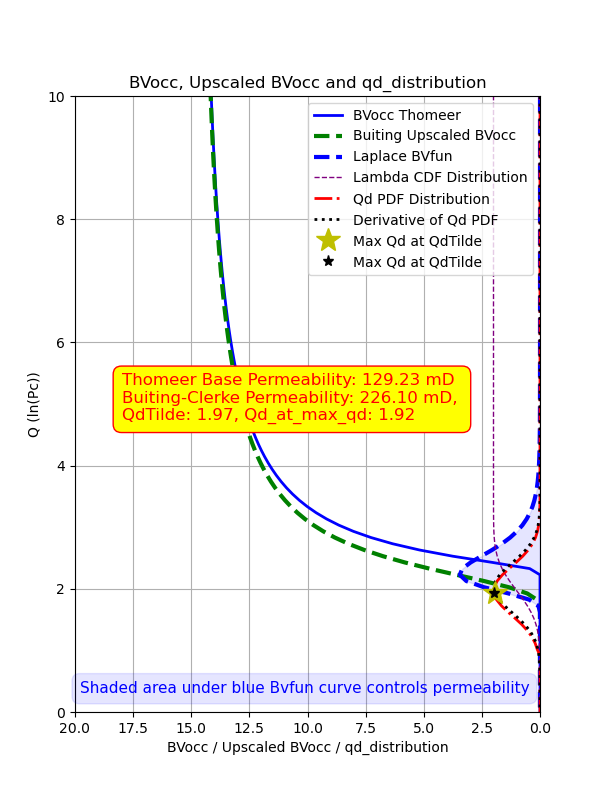

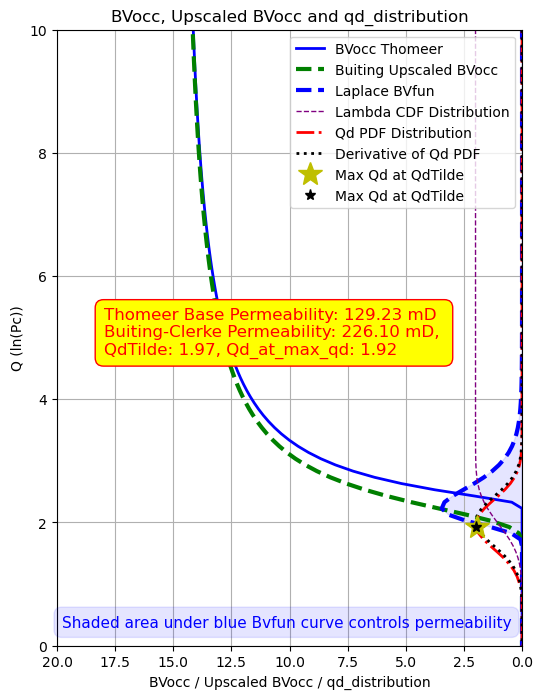

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import panel as pn
from scipy.stats import norm
from io import BytesIO

# Panel extension
pn.extension()





def sat_hg_norm(g_aver, sig_g, Qd_aver, sig_Qd, Q):
    """
    Calculate Hg-saturation and QdTilde based on Gaussian distributions.
    """
    delta_g = 0.5 * sig_g**2 / g_aver

    #def gaussian_cdf( x,       mu,         sigma):
    Lambda  = norm.cdf(Q, Qd_aver - delta_g, sig_Qd)
    Gauss   = norm.pdf(Q, Qd_aver - delta_g, sig_Qd)

    ####QdTilde = Q * (1 - Lambda) + (Qd_aver - delta_g) * Lambda - sig_Qd**2 * Gauss 
    QdTilde = Q * (1 - Lambda) + (Qd_aver - delta_g) * Lambda - sig_Qd**2 * Gauss

    if Q > Qd_aver - 3 * sig_Qd:
        sat = np.exp(-g_aver / (Q - QdTilde))
    else:
        sat = 0

    return sat, QdTilde 



def calculate_permeability(BV1, G1, Pd1, q_values, bvocc_values, QdTilde, sig_Qd):
    """
    Calculate Buiting-Clerke permeability based on upscaled and Thomeer permeabilities.
    Ksi = ξ =   2[sigma * cos(θ)]Hg–Air ≈ 734 dyn/cm = 107 psi μm
    Thomeer_perm_paper from equation 35 in BC paper converted to mD used as base perm

    """
    D_lambda, LLd, Ksi = 1.56, 0.5, 107

    BVfun     = np.where(q_values >= (QdTilde - 3 * sig_Qd), bvocc_values * np.exp(-2 * D_lambda * q_values), 0.0)
    BVfun_sum = np.sum(BVfun)
    Constant  = (np.exp(-2 * (1 - D_lambda) * QdTilde) * (D_lambda / 4)) * LLd ** 2
    Perm_BC_intermediate = BVfun_sum * Constant * Ksi ** 2

    Thomeer_perm_paper = 10**3 * (506 * (BV1 / 100) / (Pd1 ** 2)) * np.exp(-4.43 * (G1 ** 0.5))
    Perm_BC = Thomeer_perm_paper + Perm_BC_intermediate / 3

    return Perm_BC, Thomeer_perm_paper



def plot_upscale(BV1, G1, Pd1, sig_G1, sig_Qd):
    """
    Generate the BVocc, Thomeer, and Buiting-Clerke permeability plots.
    g_aver = 2.3 * G1
    sig_g  = 2.3 * sig_G1
    Qd_aver= np.log(Pd1)
    """
    g_aver, sig_g = 2.3 * G1, 2.3 * sig_G1
    Qd_aver = np.log(Pd1)

    q_values = np.linspace(-1, 11.0, 120)
    bvocc_values, bvocc_values_thomeer, qd_distribution, lambda_distribution = [], [], [], []

    for Q in q_values:
        ''' Upscaled BVocc'''
        #sat, QdTilde , Lambda, Gauss= sat_hg_norm(g_aver, sig_g, Qd_aver, sig_Qd, Q)
        sat, QdTilde = sat_hg_norm(g_aver, sig_g, Qd_aver, sig_Qd, Q)
        bvocc_values.append(sat * BV1)

        ''' Regular Thomeer BVocc'''
        if Q > Qd_aver:
            sat_thomeer = np.exp(-g_aver / (Q - Qd_aver))
        else:
            sat_thomeer = 0
        bvocc_values_thomeer.append(sat_thomeer * BV1)

        ''' qd_distribution'''
        delta_g = 0.5 * sig_g**2 / g_aver
        Gauss   = norm.pdf(Q, Qd_aver -delta_g, sig_Qd)
        qd_distribution.append(2 * Gauss if abs(Q - Qd_aver) <= 3 * sig_Qd else 0) # 2*Gauss is so we can see it on the plot better

        ''' Lambda_distribution'''
        Lambda  = norm.cdf(Q, Qd_aver - delta_g, sig_Qd)
        lambda_distribution.append( 2  * Lambda)

    # Calculate the derivative of qd_distribution
    dq_dQ = np.diff(lambda_distribution) / np.diff(q_values)
    # Insert zero at the beginning to maintain array length
    dq_dQ = np.insert(dq_dQ, 0, 0)



    ''' Buiting-Clerke Permeability '''
    Perm_BC, Thomeer_perm_paper = calculate_permeability(BV1, G1, Pd1, q_values, bvocc_values, QdTilde, sig_Qd)

    # Find max in qd_distribution and corresponding Q value
    max_qd_index = np.argmax(qd_distribution)
    Q_at_max_qd = q_values[max_qd_index]
    max_qd_value = qd_distribution[max_qd_index]

    # Find max in dq_Qd_distribution and corresponding Q value
    max_qd_dQ_index = np.argmax(qd_distribution)
    Qd_at_max_qd = q_values[max_qd_dQ_index ]
    max_qd_dQ_value = dq_dQ[max_qd_dQ_index]

    sig_g = 2.3 * sig_G1
    delta_g = 0.5 * sig_g**2 / g_aver
    
    
    ''' Plotting of Upscaled data '''
    plt.close('all')
    fig, ax = plt.subplots(figsize=(6, 8))
    ax.plot(bvocc_values_thomeer, q_values, label='BVocc Thomeer', color='blue', linewidth=2)
    ax.plot(bvocc_values, q_values, label='Buiting Upscaled BVocc', color='green', linestyle='--', linewidth=3)
    ax.plot(10**3 * np.array(bvocc_values) * np.exp(-2 * 1.56 * q_values), q_values, label='Laplace BVfun', color='blue', linestyle='--', linewidth=3)
    ax.fill_betweenx(q_values, 10**3 * np.array(bvocc_values) * np.exp(-2 * 1.56 * q_values), 0.01, color='blue', alpha=0.1)
    ax.plot(lambda_distribution, q_values, label='Lambda CDF Distribution', color='purple', linestyle='--', linewidth=1)
    ax.plot(qd_distribution, q_values, label='Qd PDF Distribution', color='red', linestyle='-.', linewidth=2)
    ax.plot(dq_dQ, q_values, label='Derivative of Qd PDF', color='black', linestyle=':', linewidth=2)


    
    # Plot a '*' at the max of qd_distribution at QdTilde
    ax.plot(max_qd_dQ_value, Qd_at_max_qd, 'y*', markersize=18, label='Max Qd at QdTilde')

    # Plot a '*' at the max of qd_distribution at QdTilde
    ax.plot(max_qd_value, Q_at_max_qd, 'k*', markersize=8, label='Max Qd at QdTilde')

    # Text and labels
    text_string = f'Thomeer Base Permeability: {Thomeer_perm_paper:.2f} mD \nBuiting-Clerke Permeability: {Perm_BC:.2f} mD, \nQdTilde: {round(QdTilde,2)}, Qd_at_max_qd: {round(Qd_at_max_qd ,2)}'
    ax.text(0.1, 0.55, text_string, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='red', facecolor='yellow'),
            color='red')

    text_string2 = f'Shaded area under blue Bvfun curve controls permeability'
    ax.text(0.01, 0.05, text_string2, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='blue', facecolor='blue',alpha=0.1),
        color='blue')

    ax.set_ylabel('Q (ln(Pc))')
    ax.set_xlabel('BVocc / Upscaled BVocc / qd_distribution')
    ax.set_xlim(20, 0)
    ax.set_ylim(0, 10)
    ax.set_title('BVocc, Upscaled BVocc and qd_distribution')
    ax.legend(loc='upper right')    
    ax.grid(True)

    return fig






''' Main Body of program featuring panel used for interactive slide bars '''
# Thomeer parameters and sliders for interactive use
BV1, G1, Pd1, sig_G1, sig_Qd = 15, 0.2, 9, 0.2, 0.4

BV1_slider     = pn.widgets.FloatSlider(name='BV1', start=0.0, end=40, step=0.5, value=BV1)
G1_slider      = pn.widgets.FloatSlider(name='G1', start=0.01, end=4, step=0.01, value=G1)
Pd1_slider     = pn.widgets.FloatSlider(name='Pd1', start=1, end=500, step=0.1, value=Pd1)
sig_G1_slider  = pn.widgets.FloatSlider(name='sig_G1', start=0.01, end=2, step=0.01, value=sig_G1)
sig_Qd_slider  = pn.widgets.FloatSlider(name='sig_Qd', start=0.01, end=2, step=0.01, value=sig_Qd)


@pn.depends(BV1_slider.param.value, G1_slider.param.value, Pd1_slider.param.value, sig_G1_slider.param.value, sig_Qd_slider.param.value)
def interactive_plot(BV1, G1, Pd1, sig_G1, sig_Qd):
    fig = plot_upscale(BV1, G1, Pd1, sig_G1, sig_Qd)
    buf = BytesIO()
    fig.savefig(buf, format="png")
    buf.seek(0)
    return pn.pane.PNG(buf, width=600)

layout = pn.Row(
    pn.Column(BV1_slider, G1_slider, Pd1_slider, sig_G1_slider, sig_Qd_slider),
    interactive_plot
)




layout.servable()


Row
    [0] Column
        [0] FloatSlider(end=40, name='BV1', step=0.5, value=15)
        [1] FloatSlider(end=4, name='G1', start=0.01, step=0.01, value=0.2)
        [2] FloatSlider(end=500, name='Pd1', start=1, value=9)
        [3] FloatSlider(end=2, name='sig_G1', start=0.01, step=0.01, value=0.2)
        [4] FloatSlider(end=2, name='sig_Qd', start=0.01, step=0.01, value=0.4)
    [1] ParamFunction(function, _pane=PNG, defer_load=False)
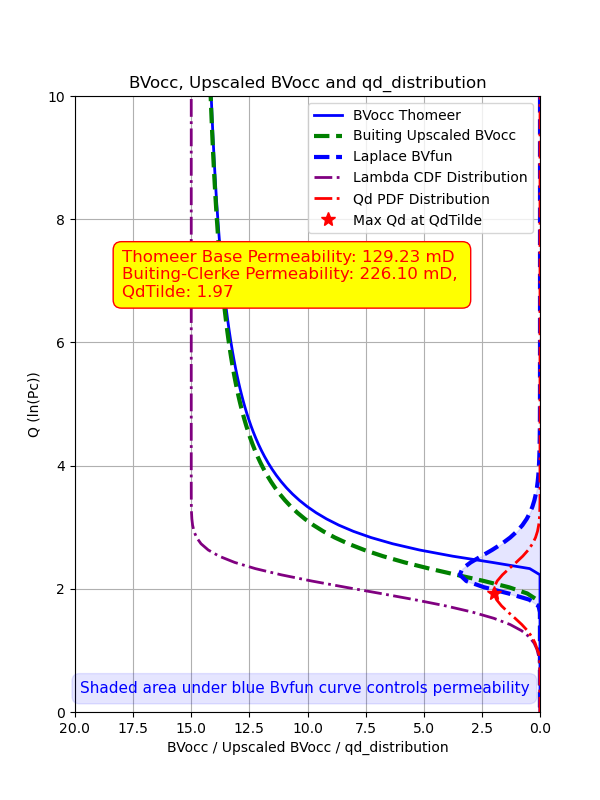

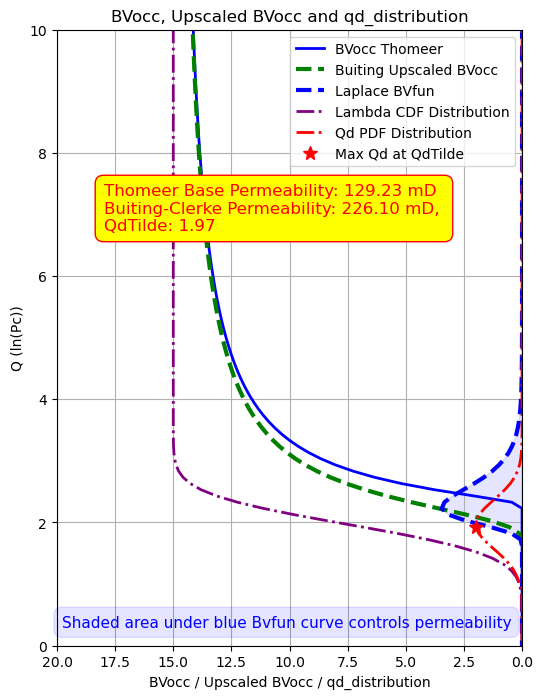

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import panel as pn
from scipy.stats import norm
from io import BytesIO

# Panel extension
pn.extension()

def sat_hg_norm(g_aver, sig_g, Qd_aver, sig_Qd, Q):
    """
    Calculate Hg-saturation and QdTilde based on Gaussian distributions.
    """
    delta_g = 0.5 * sig_g**2 / g_aver
    Lambda  = norm.cdf(Q, Qd_aver - delta_g, sig_Qd)
    Gauss   = norm.pdf(Q, Qd_aver - delta_g, sig_Qd)
    QdTilde = Q * (1 - Lambda) + (Qd_aver - delta_g) * Lambda - sig_Qd**2 * Gauss

    if Q > Qd_aver - 3 * sig_Qd:
        sat = np.exp(-g_aver / (Q - QdTilde))
    else:
        sat = 0

    return sat, QdTilde 

def calculate_permeability(BV1, G1, Pd1, q_values, bvocc_values, QdTilde, sig_Qd):
    D_lambda, LLd, Ksi = 1.56, 0.5, 107
    BVfun = np.where(q_values >= (QdTilde - 3 * sig_Qd), bvocc_values * np.exp(-2 * D_lambda * q_values), 0.0)
    BVfun_sum = np.sum(BVfun)
    Constant  = (np.exp(-2 * (1 - D_lambda) * QdTilde) * (D_lambda / 4)) * LLd ** 2
    Perm_BC_intermediate = BVfun_sum * Constant * Ksi ** 2

    Thomeer_perm_paper = 10**3 * (506 * (BV1 / 100) / (Pd1 ** 2)) * np.exp(-4.43 * (G1 ** 0.5))
    Perm_BC = Thomeer_perm_paper + Perm_BC_intermediate / 3

    return Perm_BC, Thomeer_perm_paper

def plot_upscale(BV1, G1, Pd1, sig_G1, sig_Qd):
    g_aver, sig_g = 2.3 * G1, 2.3 * sig_G1
    Qd_aver = np.log(Pd1)

    q_values = np.linspace(-1, 11.0, 120)
    bvocc_values, bvocc_values_thomeer, qd_distribution, lambda_distribution = [], [], [], []

    for Q in q_values:
        sat, QdTilde = sat_hg_norm(g_aver, sig_g, Qd_aver, sig_Qd, Q)
        bvocc_values.append(sat * BV1)

        if Q > Qd_aver:
            sat_thomeer = np.exp(-g_aver / (Q - Qd_aver))
        else:
            sat_thomeer = 0
        bvocc_values_thomeer.append(sat_thomeer * BV1)

        delta_g = 0.5 * sig_g**2 / g_aver
        Gauss   = norm.pdf(Q, Qd_aver - delta_g, sig_Qd)
        qd_distribution.append(2 * Gauss if abs(Q - Qd_aver) <= 3 * sig_Qd else 0)

        Lambda  = norm.cdf(Q, Qd_aver - delta_g, sig_Qd)
        lambda_distribution.append(BV1 * Lambda)

    Perm_BC, Thomeer_perm_paper = calculate_permeability(BV1, G1, Pd1, q_values, bvocc_values, QdTilde, sig_Qd)

    # Find max in qd_distribution and corresponding Q value
    max_qd_index = np.argmax(qd_distribution)
    Q_at_max_qd = q_values[max_qd_index]
    max_qd_value = qd_distribution[max_qd_index]

    plt.close('all')
    fig, ax = plt.subplots(figsize=(6, 8))
    ax.plot(bvocc_values_thomeer, q_values, label='BVocc Thomeer', color='blue', linewidth=2)
    ax.plot(bvocc_values, q_values, label='Buiting Upscaled BVocc', color='green', linestyle='--', linewidth=3)
    ax.plot(10**3 * np.array(bvocc_values) * np.exp(-2 * 1.56 * q_values), q_values, label='Laplace BVfun', color='blue', linestyle='--', linewidth=3)
    ax.fill_betweenx(q_values, 10**3 * np.array(bvocc_values) * np.exp(-2 * 1.56 * q_values), 0.01, color='blue', alpha=0.1)
    ax.plot(lambda_distribution, q_values, label='Lambda CDF Distribution', color='purple', linestyle='-.', linewidth=2)
    ax.plot(qd_distribution, q_values, label='Qd PDF Distribution', color='red', linestyle='-.', linewidth=2)

    # Plot a '*' at the max of qd_distribution at QdTilde
    ax.plot(max_qd_value, Q_at_max_qd, 'r*', markersize=10, label='Max Qd at QdTilde')

    # Text and labels
    text_string = f'Thomeer Base Permeability: {Thomeer_perm_paper:.2f} mD \nBuiting-Clerke Permeability: {Perm_BC:.2f} mD, \nQdTilde: {round(QdTilde,2)}'
    ax.text(0.1, 0.75, text_string, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='red', facecolor='yellow'),
            color='red')

    text_string2 = f'Shaded area under blue Bvfun curve controls permeability'
    ax.text(0.01, 0.05, text_string2, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', edgecolor='blue', facecolor='blue',alpha=0.1),
        color='blue')

    ax.set_ylabel('Q (ln(Pc))')
    ax.set_xlabel('BVocc / Upscaled BVocc / qd_distribution')
    ax.set_xlim(20, 0)
    ax.set_ylim(0, 10)
    ax.set_title('BVocc, Upscaled BVocc and qd_distribution')
    ax.legend()
    ax.grid(True)

    return fig


''' Main Body of program featuring panel used for interactive slide bars '''
# Thomeer parameters and sliders for interactive use
BV1, G1, Pd1, sig_G1, sig_Qd = 15, 0.2, 9, 0.2, 0.4

BV1_slider     = pn.widgets.FloatSlider(name='BV1', start=0.0, end=40, step=0.5, value=BV1)
G1_slider      = pn.widgets.FloatSlider(name='G1', start=0.01, end=4, step=0.01, value=G1)
Pd1_slider     = pn.widgets.FloatSlider(name='Pd1', start=1, end=500, step=0.1, value=Pd1)
sig_G1_slider  = pn.widgets.FloatSlider(name='sig_G1', start=0.01, end=2, step=0.01, value=sig_G1)
sig_Qd_slider  = pn.widgets.FloatSlider(name='sig_Qd', start=0.01, end=2, step=0.01, value=sig_Qd)


@pn.depends(BV1_slider.param.value, G1_slider.param.value, Pd1_slider.param.value, sig_G1_slider.param.value, sig_Qd_slider.param.value)
def interactive_plot(BV1, G1, Pd1, sig_G1, sig_Qd):
    fig = plot_upscale(BV1, G1, Pd1, sig_G1, sig_Qd)
    buf = BytesIO()
    fig.savefig(buf, format="png")
    buf.seek(0)
    return pn.pane.PNG(buf, width=600)

layout = pn.Row(
    pn.Column(BV1_slider, G1_slider, Pd1_slider, sig_G1_slider, sig_Qd_slider),
    interactive_plot
)




layout.servable()


This is a breakdown of the `sat_hg_norm` function and, specifically, how `QdTilde` is calculated:

1. **`delta_g` Calculation**: 
   ```python
   delta_g = 0.5 * sig_g**2 / g_aver
   ```
   This step calculates a correction term, `delta_g`, which adjusts `Qd_aver` based on the average `g` value (`g_aver`) and its standard deviation (`sig_g`). The term `0.5 * sig_g**2 / g_aver` is derived from the Gaussian function and is often used in the context of lognormal distributions or to account for skewed distributions.

2. **`Lambda` and `Gauss` Calculation**:
   ```python
   Lambda = norm.cdf(Q, Qd_aver - delta_g, sig_Qd)
   Gauss = norm.pdf(Q, Qd_aver - delta_g, sig_Qd)
   ```
   - **`Lambda`**: This is the cumulative distribution function (CDF) of a Gaussian distribution with mean `(Qd_aver - delta_g)` and standard deviation `sig_Qd`. `Lambda` gives the cumulative probability up to the value `Q`, which means it represents the probability that a value drawn from this distribution is less than or equal to `Q`.
   - **`Gauss`**: This is the probability density function (PDF) of the same Gaussian distribution, evaluated at `Q`. `Gauss` provides the likelihood of `Q` for a Gaussian with the specified mean and standard deviation.

3. **`QdTilde` Calculation**:
   ```python
   QdTilde = Q * (1 - Lambda) + (Qd_aver - delta_g) * Lambda - sig_Qd**2 * Gauss 
   ```


   `QdTilde` is computed as a weighted sum of `Q` and `(Qd_aver - delta_g)`, adjusted by the cumulative probability (`Lambda`) and the probability density (`Gauss`). Here’s what each term does:
   
   - **`Q * (1 - Lambda)`**: This term weights the input `Q` by `(1 - Lambda)`, giving higher importance to `Q` when `Lambda` is small (i.e., when `Q` is significantly less than `Qd_aver - delta_g`).
   - **`(Qd_aver - delta_g) * Lambda`**: This term weights `(Qd_aver - delta_g)` by `Lambda`, giving higher importance to `(Qd_aver - delta_g)` as `Q` approaches `Qd_aver - delta_g` (when `Lambda` is larger).
   - **`- sig_Qd**2 * Gauss`**: This term adjusts `QdTilde` based on the likelihood (`Gauss`) of `Q`. By subtracting `sig_Qd**2 * Gauss`, the function incorporates the spread (variance) of the distribution, adding refinement to the `QdTilde` value.

   Overall, `QdTilde` is a weighted adjusted value derived from `Q`, the Gaussian distribution's mean `(Qd_aver - delta_g)`, and the distribution's spread `sig_Qd`. This value can be thought of as a "tilde" or adjusted version of `Qd`, incorporating probabilities and densities from the Gaussian function.

5. **Hg-Saturation (`sat`) Calculation**:
   ```python
   if Q > Qd_aver - 3 * sig_Qd:
       sat = np.exp(-g_aver / (Q - QdTilde))
   else:
       sat = 0
   ```
   This part computes the saturation, `sat`, based on the exponential relationship with `Q` and `QdTilde` if `Q` is within a reasonable range (greater than `Qd_aver - 3 * sig_Qd`).


### Summary of `QdTilde`

`QdTilde` is a complex, adjusted version of `Qd` that combines the input `Q`, a corrected average `(Qd_aver - delta_g)`, and distribution characteristics. It uses Gaussian CDF and PDF to incorporate probabilistic behavior, which refines the value of `QdTilde` in a way that likely represents some underlying distribution or property better than a single mean value would.